In [20]:
# CIFAR-10

# LeNet is not enough !?
# Hypertuning
# Data Augmentation

import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [22]:
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
training_dataset

# Long time to download the whole set (60K images, 32x32 RGB), faster on google colab!
# https://www.cs.toronto.edu/~kriz/cifar.html
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)
print('train length: ', len(training_loader), 'val length', len(validation_loader))


Files already downloaded and verified
Files already downloaded and verified
train length:  500 val length 100


In [4]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0) # move channels: Color x w x h -> w x h x color
    print(image.shape)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


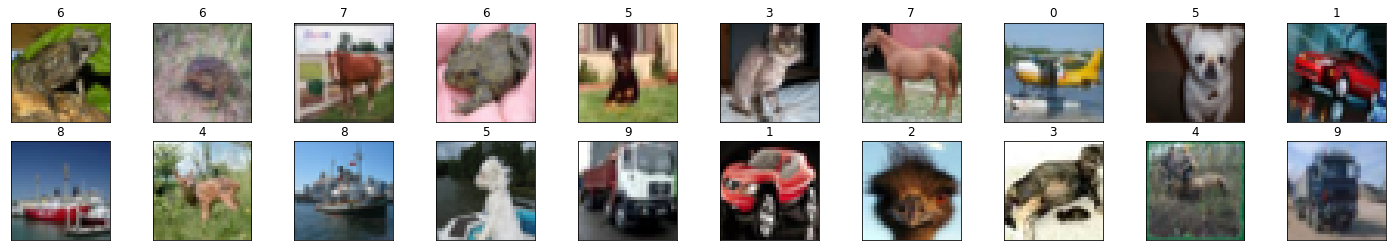

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(labels[idx].item())

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5, stride=1)
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        # self.conv1 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) # cut by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2) # cut by half
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2) # cut by half
        x = x.view(-1, 4*4*64) # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [15]:
model = LeNet().to(device)
model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [9]:
epochs = 12
running_loss_history = []
running_corrects_history = []

val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # inputs = inputs.view(inputs.shape[0], -1) #1, 28, 28 -> flatten: 1, 784
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss= criterion(val_outputs, val_labels)
                
                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader)
        epoch_acc = running_corrects.float() / len(training_loader)
        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects.float() / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)

        print('epoch: ', e+1)
        print('training loss: {:.4f}, acc: {:.4f}'.format(epoch_loss, epoch_acc))
        print('validation loss: {:.4f}, validation acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    

epoch:  1
training loss: 1.5673, acc: 42.7320
validation loss: 1.2930, validation acc: 52.6500
epoch:  2
training loss: 1.1983, acc: 57.1880
validation loss: 1.1212, validation acc: 59.5500
epoch:  3
training loss: 1.0324, acc: 63.2920
validation loss: 1.0016, validation acc: 64.3900
epoch:  4
training loss: 0.9213, acc: 67.4260
validation loss: 0.9285, validation acc: 67.8800
epoch:  5
training loss: 0.8357, acc: 70.7140
validation loss: 0.9091, validation acc: 68.5600
epoch:  6
training loss: 0.7721, acc: 72.8260
validation loss: 0.9076, validation acc: 68.3700
epoch:  7
training loss: 0.7098, acc: 74.8580
validation loss: 0.8594, validation acc: 70.8900
epoch:  8
training loss: 0.6726, acc: 76.3520
validation loss: 0.8812, validation acc: 70.6700
epoch:  9
training loss: 0.6251, acc: 77.8920
validation loss: 0.8615, validation acc: 71.1700
epoch:  10
training loss: 0.5831, acc: 79.3700
validation loss: 0.8585, validation acc: 71.1000
epoch:  11
training loss: 0.5511, acc: 80.3100
va

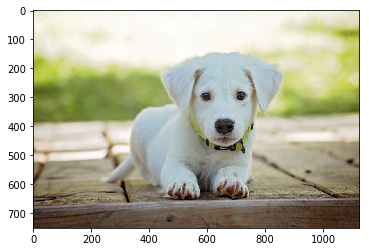

In [18]:
import requests
from PIL import Image
import PIL.ImageOps

url = 'https://images.pexels.com/photos/257540/pexels-photo-257540.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

(32, 32, 3)


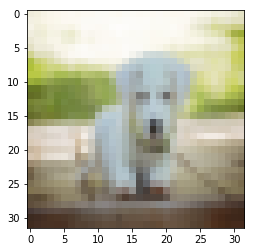

In [19]:
img = transform(img)
plt.imshow(im_convert(img))

In [12]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

plane


(32, 32, 3)
frog


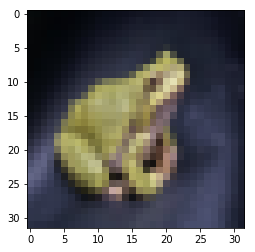

In [13]:
def predict_image(url):
    response = requests.get(url, stream=True)
    img = Image.open(response.raw)
    plt.imshow(img)
    img = transform(img)
    plt.imshow(im_convert(img))
    image = img.to(device).unsqueeze(0)
    output = model(image)
    _, pred = torch.max(output, 1)
    print(classes[pred.item()])

url = 'https://images.pexels.com/photos/70083/frog-macro-amphibian-green-70083.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500'
# url = 'https://images.pexels.com/photos/257540/pexels-photo-257540.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260'
predict_image(url)


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


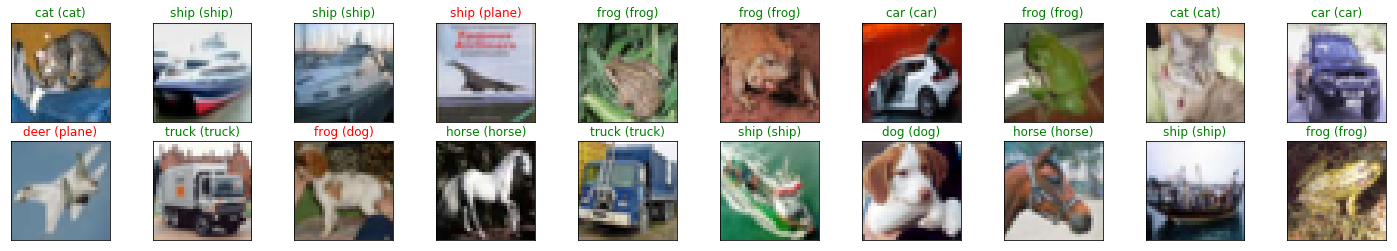

In [14]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# images_ = images.view(images.shape[0],-1)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format( classes[preds[idx].item()], classes[labels[idx].item()]), 
                 color = ('green' if preds[idx] == labels[idx] else 'red')  )

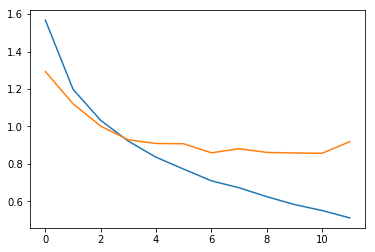

In [16]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')

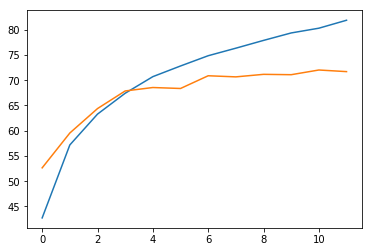

In [17]:
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')